In [8]:
import MDAnalysis as mda
import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')
from MDAnalysis.analysis import align
import nglview as nv
from MDAnalysis.analysis import rms
from MDAnalysis.analysis import dihedrals
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Initialize Universe with Gromacs files
u = mda.Universe('npt_modified.gro', 'centered_nojump_md.xtc')

# Align and average structure
average = align.AverageStructure(u, u, select='protein and name CA', ref_frame=0).run()
ref = average.results.universe
aligner = align.AlignTraj(u, ref, select='protein and name CA', in_memory=True).run()

# Select a specific segment
system = u.select_atoms ('all')
alpha = u.select_atoms('bynum 1:4368')
ct_alpha = u.select_atoms('bynum 4368:4505')
beta = u.select_atoms('bynum 4506:8802')
ct_beta = u.select_atoms('bynum 8802:9035')
stalk = u.select_atoms('bynum 9036:9808', 'bynum 10732 :11596')
mtbd = u.select_atoms('bynum 9809:10726')
tublin = alpha + beta
ctails = ct_alpha + ct_beta
sys_wo_ct_stalk = system - ctails - stalk
mtbd_stalk = stalk+mtbd



In [4]:
import matplotlib.pyplot as plt

# Update the font to 'Times New Roman'
plt.rcParams["font.family"] = "Times New Roman"

# Update the font size to 12
plt.rcParams.update({'font.size': 12})

import matplotlib.ticker as ticker

def setup_plot(x_label, y_label, xmin=None, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.tick_params(labelsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    if xmin is not None and xmax is not None:
        ax.set_xlim(left=xmin, right=(xmax*1.05))
    if ymin is not None and ymax is not None:
        ax.set_ylim(bottom=ymin, top=(ymax*1.15))

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    return fig, ax

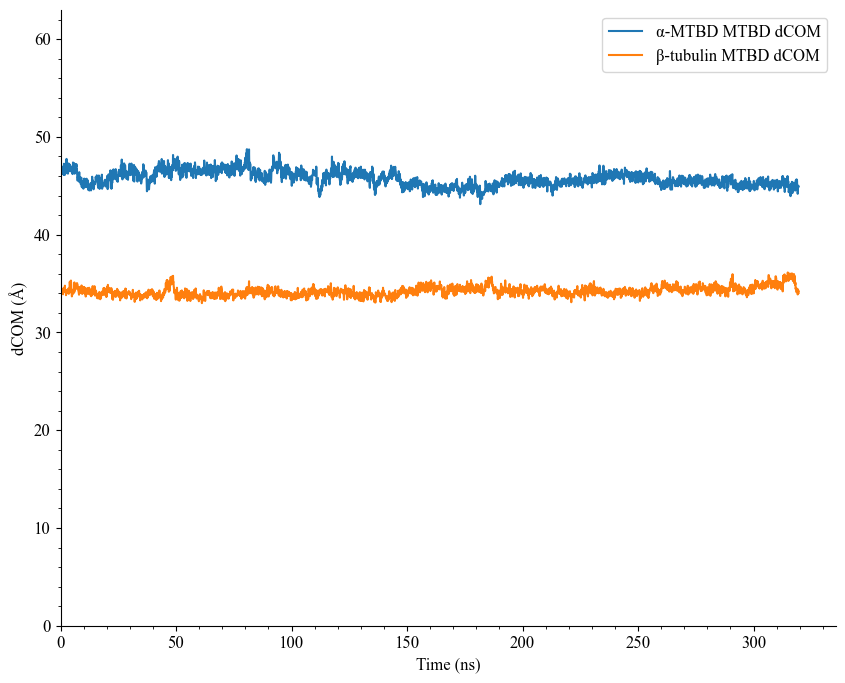

Initial dCOM for alpha:  46.45581561817398
Final dCOM for alpha:  44.91825587328335
Initial dCOM for beta:  34.5351272932084
Final dCOM for beta:  34.03533345290372


In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Update the font to 'Times New Roman'
plt.rcParams["font.family"] = "Times New Roman"

# Update the font size to 12
plt.rcParams.update({'font.size': 12})

# Your alpha, beta and mtbd selections
alpha = u.select_atoms('bynum 1:4368')
beta = u.select_atoms('bynum 4506:8802')
mtbd = u.select_atoms('bynum 9809:10726')

# Lists to store the dCOM values
dcom_values_alpha = []
dcom_values_beta = []

# Loop over the trajectory
for ts in u.trajectory:
    dcom_alpha = np.linalg.norm(alpha.center_of_mass() - mtbd.center_of_mass())
    dcom_beta = np.linalg.norm(beta.center_of_mass() - mtbd.center_of_mass())
    dcom_values_alpha.append(dcom_alpha)
    dcom_values_beta.append(dcom_beta)

# Generate the x-values (time in nanoseconds)
time = np.arange(len(dcom_values_alpha)) * u.trajectory.dt / 1000

# Create a DataFrame
df = pd.DataFrame({
    'Time (ns)': time, 
    'Alpha DCOM (Å)': dcom_values_alpha, 
    'Beta DCOM (Å)': dcom_values_beta
})

# Calculate the rolling average with a window size of 100
df['Smoothed Alpha DCOM (Å)'] = df['Alpha DCOM (Å)'].rolling(window=1).mean()
df['Smoothed Beta DCOM (Å)'] = df['Beta DCOM (Å)'].rolling(window=1).mean()

# Define the setup plot function
def setup_plot(x_label, y_label, xmin=None, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.tick_params(labelsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    
    ax.set_xlim(left=xmin, right=(xmax*1.05))
    ax.set_ylim(bottom=ymin, top=(ymax*1.05))

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    return fig, ax

# Setup the plot
fig, ax = setup_plot('Time (ns)', 'dCOM (Å)', xmin=0, xmax=time.max(), ymin=0, ymax=60)

# Plot the smoothed DCOM values using seaborn
sns.lineplot(x='Time (ns)', y='Smoothed Alpha DCOM (Å)', data=df, ax=ax, label='α-MTBD MTBD dCOM')
sns.lineplot(x='Time (ns)', y='Smoothed Beta DCOM (Å)', data=df, ax=ax, label='β-tubulin MTBD dCOM')

plt.legend()
plt.savefig("Final Graphs/Smoothed_DCOM_Alpha_Beta_MTBD.png", dpi=300)
plt.show()

# Print initial and final dCOM values for alpha
print("Initial dCOM for alpha: ", dcom_values_alpha[1])
print("Final dCOM for alpha: ", dcom_values_alpha[-1])

# Print initial and final dCOM values for beta
print("Initial dCOM for beta: ", dcom_values_beta[1])
print("Final dCOM for beta: ", dcom_values_beta[-1])


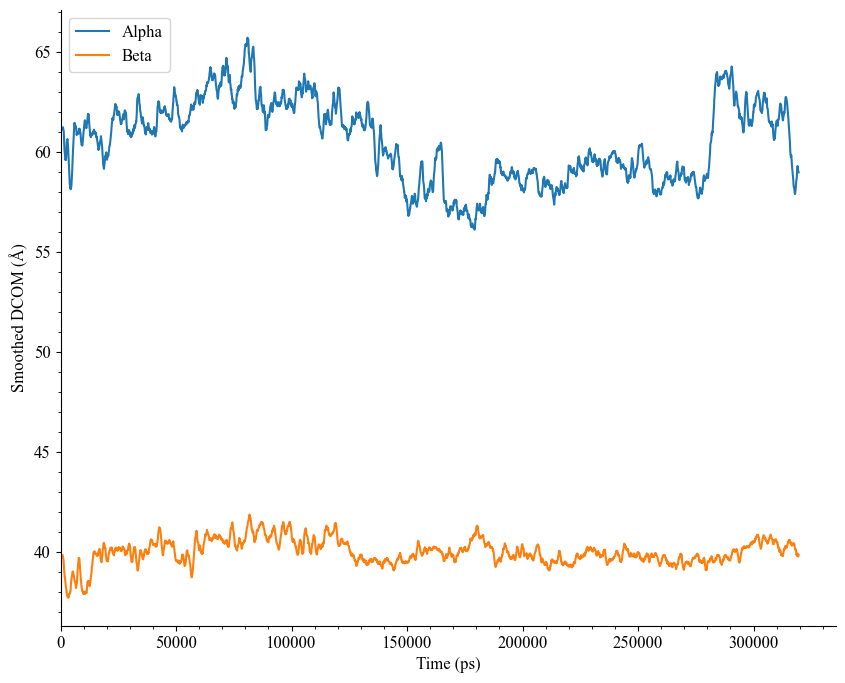

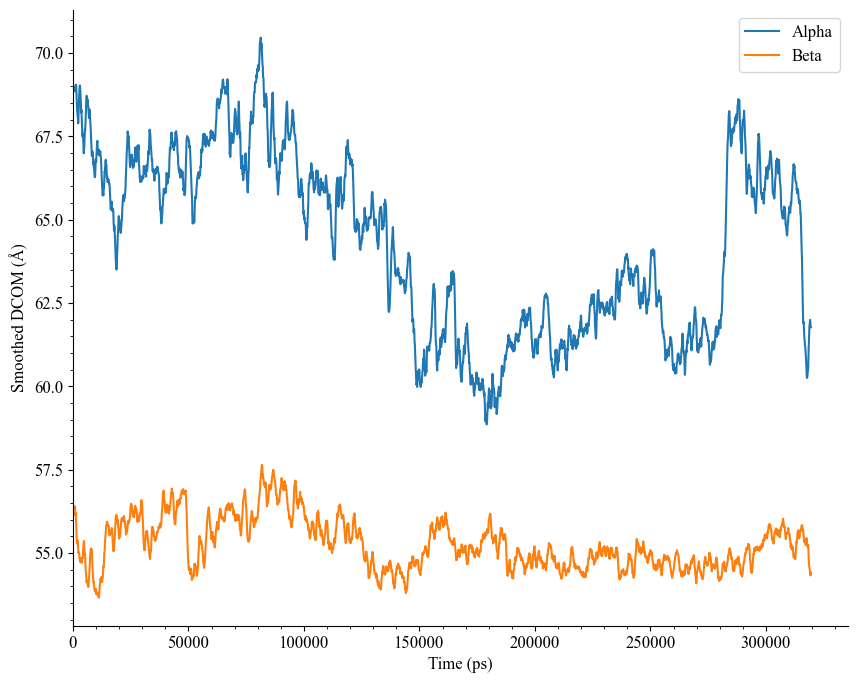

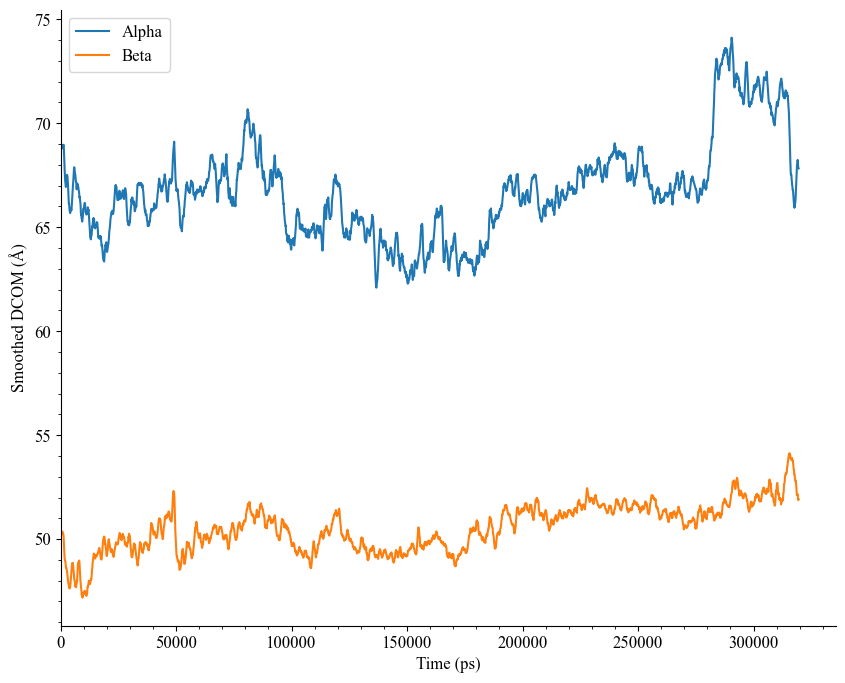

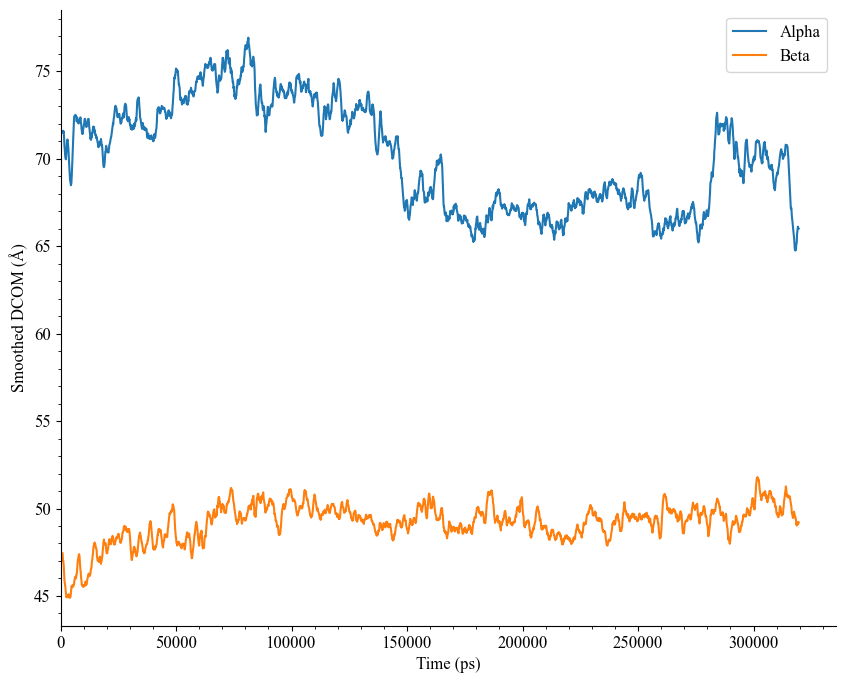

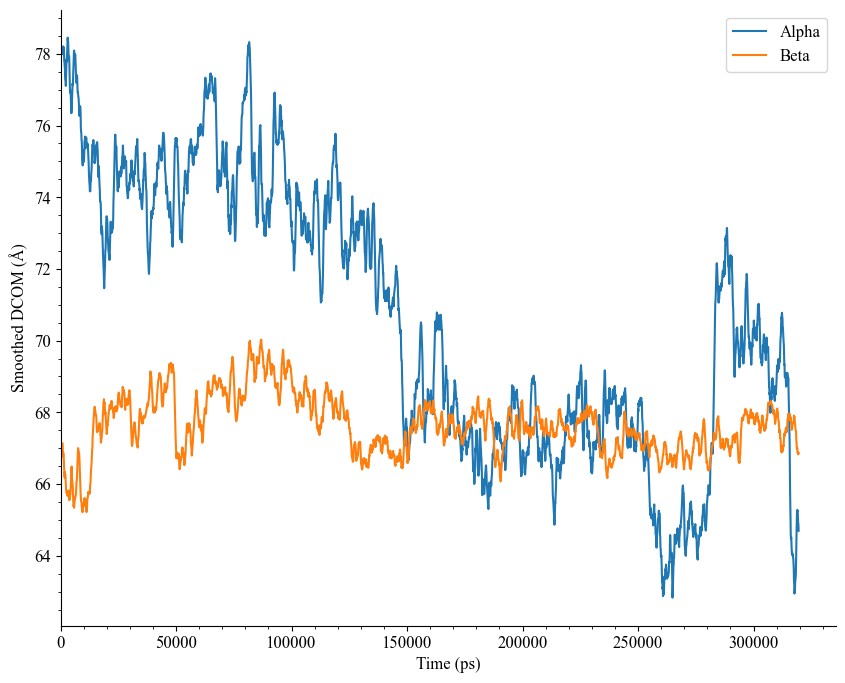

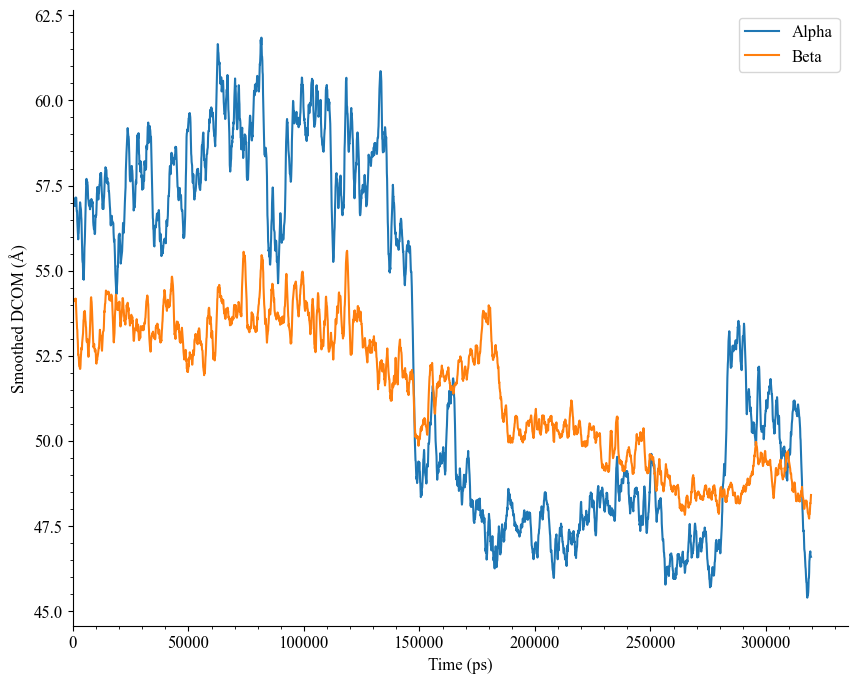

In [15]:
import MDAnalysis as mda
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Update the font to 'Times New Roman'
plt.rcParams["font.family"] = "Times New Roman"

# Update the font size to 12
plt.rcParams.update({'font.size': 12})

def setup_plot(x_label, y_label, xmin=None, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.tick_params(labelsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    if xmin is not None and xmax is not None:
        ax.set_xlim(left=xmin, right=(xmax*1.05))
    if ymin is not None and ymax is not None:
        ax.set_ylim(bottom=ymin, top=(ymax*1.15))

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    return fig, ax

# Initialize Universe with Gromacs files
u = mda.Universe('npt_modified.gro', 'centered_nojump_md.xtc')

# Select ct_alpha and ct_beta
ct_alpha = u.select_atoms('bynum 4368:4505')
ct_beta = u.select_atoms('bynum 8802:9035')

# Select the MTBD helices
mtbd_selections = {
    'mtbd_H1': u.select_atoms('resid 3301:3309'),
    'mtbd_H2': u.select_atoms('resid 3315:3329'),
    'mtbd_H3': u.select_atoms('resid 3335:3341'),
    'mtbd_H4': u.select_atoms('resid 3347:3352'),
    'mtbd_H5': u.select_atoms('resid 3361:3370'),
    'mtbd_H6': u.select_atoms('resid 3379:3385'),
}

# Dataframe to store dCOM results
df = pd.DataFrame()

# Time in ps
time = None

# Loop over each MTBD selection
for selection_name, selection in mtbd_selections.items():
    dcom_values_alpha = []
    dcom_values_beta = []
    for ts in u.trajectory:
        dcom_alpha = np.linalg.norm(ct_alpha.center_of_mass() - selection.center_of_mass())
        dcom_beta = np.linalg.norm(ct_beta.center_of_mass() - selection.center_of_mass())
        dcom_values_alpha.append(dcom_alpha)
        dcom_values_beta.append(dcom_beta)
    time = np.arange(len(dcom_values_alpha)) * u.trajectory.dt  # time in ps
    df[selection_name + ' Alpha DCOM (Å)'] = dcom_values_alpha
    df[selection_name + ' Beta DCOM (Å)'] = dcom_values_beta




Initial dCOM for MTBD-H1 Alpha: 60.34508121574376
Final dCOM for MTBD-H1 Alpha: 58.501565380044404
Initial dCOM for MTBD-H1 Beta: 39.224680534255654
Final dCOM for MTBD-H1 Beta: 39.60510401346105
Initial dCOM for MTBD-H2 Alpha: 68.25968221673021
Final dCOM for MTBD-H2 Alpha: 61.4528000053468
Initial dCOM for MTBD-H2 Beta: 56.46104234062834
Final dCOM for MTBD-H2 Beta: 54.33421273318643
Initial dCOM for MTBD-H3 Alpha: 67.21632619243722
Final dCOM for MTBD-H3 Alpha: 67.75347066612906
Initial dCOM for MTBD-H3 Beta: 49.13964302507034
Final dCOM for MTBD-H3 Beta: 51.97804431416401
Initial dCOM for MTBD-H4 Alpha: 70.28819199426964
Final dCOM for MTBD-H4 Alpha: 65.83628429888755
Initial dCOM for MTBD-H4 Beta: 47.3769837372637
Final dCOM for MTBD-H4 Beta: 49.02111350775051
Initial dCOM for MTBD-H5 Alpha: 77.61041943771932
Final dCOM for MTBD-H5 Alpha: 63.72082098821051
Initial dCOM for MTBD-H5 Beta: 66.90898425536535
Final dCOM for MTBD-H5 Beta: 66.51789386786038
Initial dCOM for MTBD-H6 Alpha

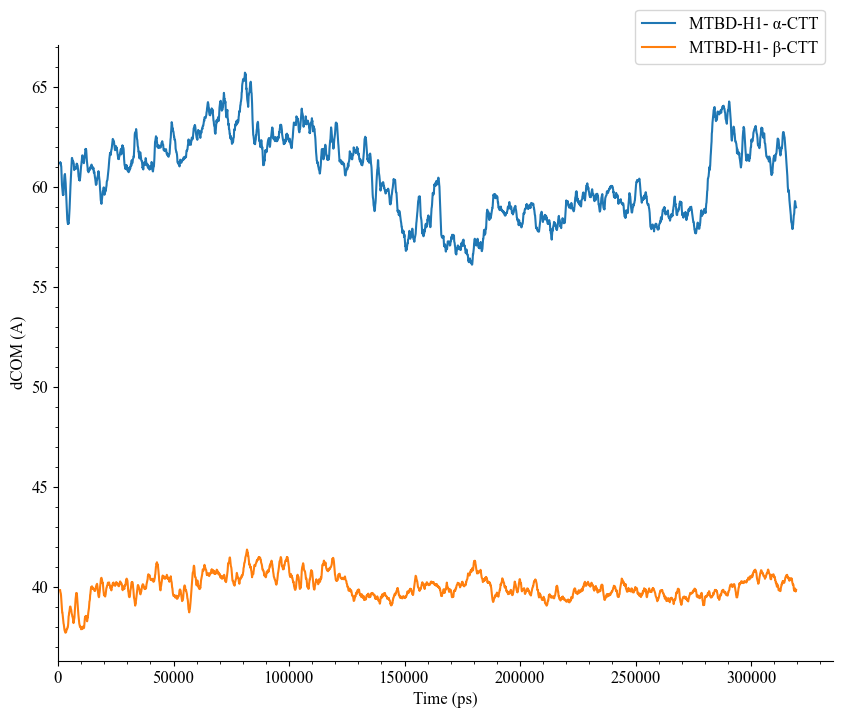

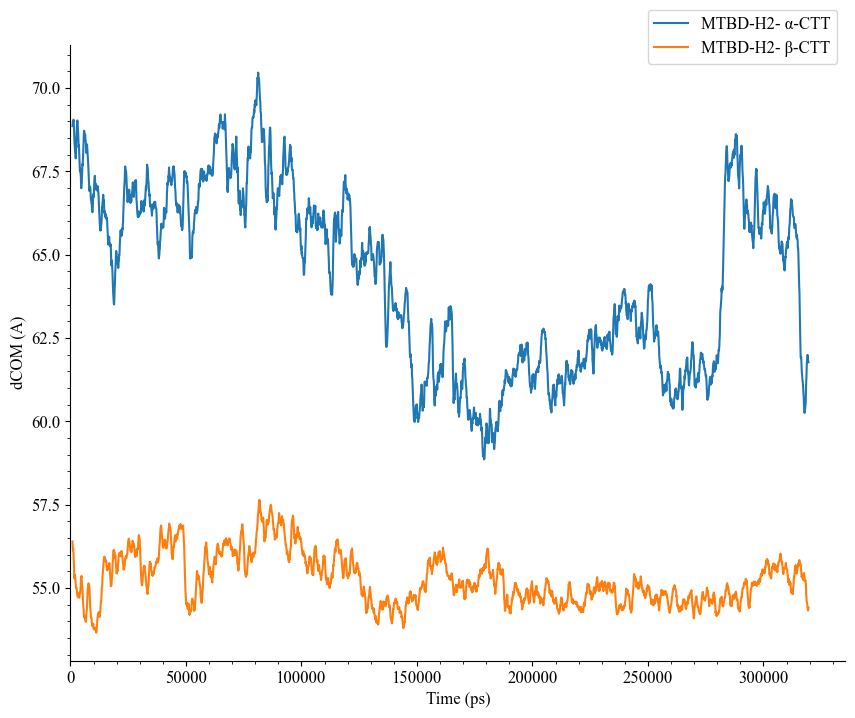

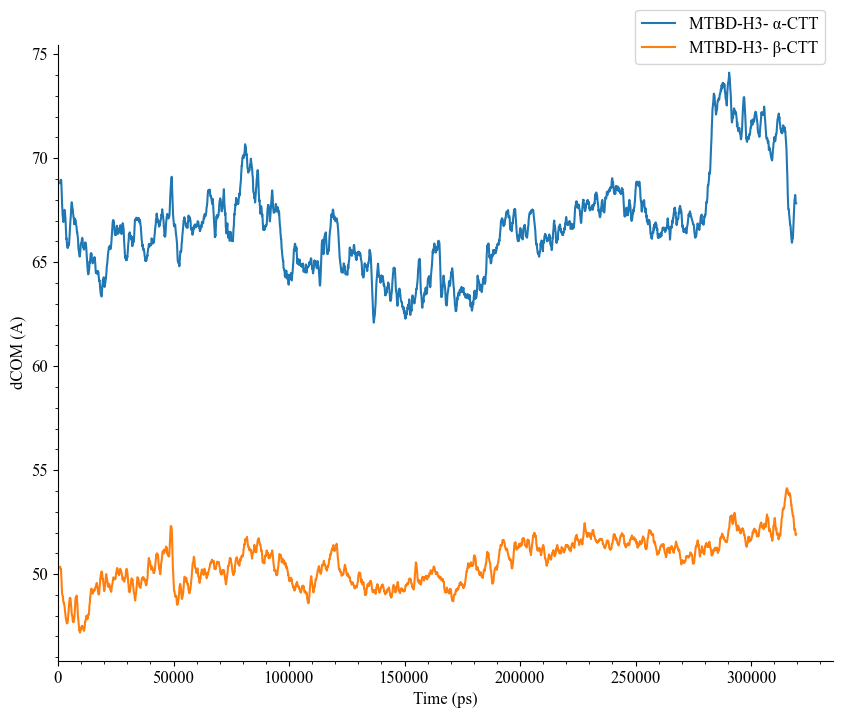

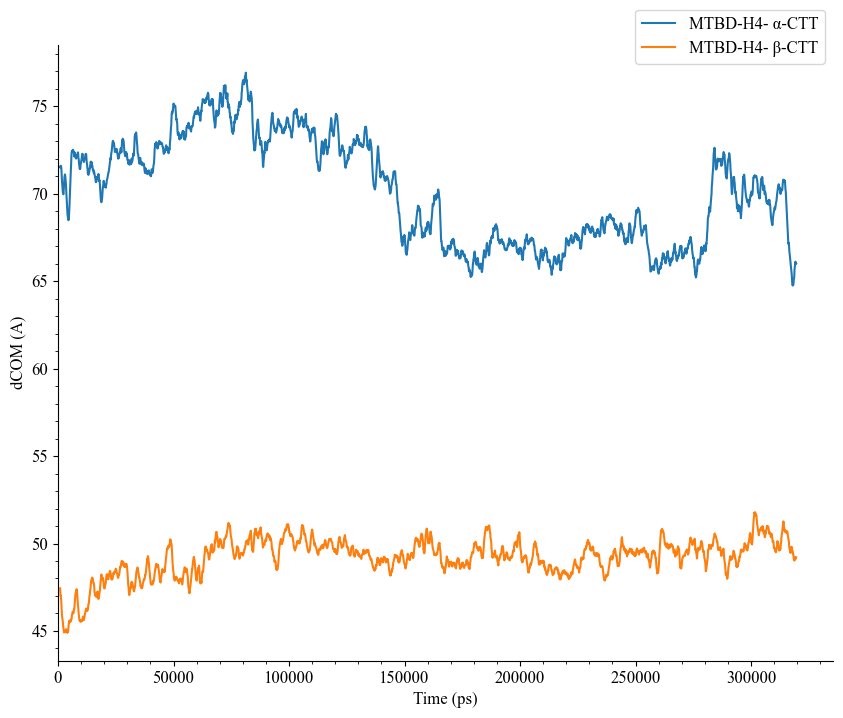

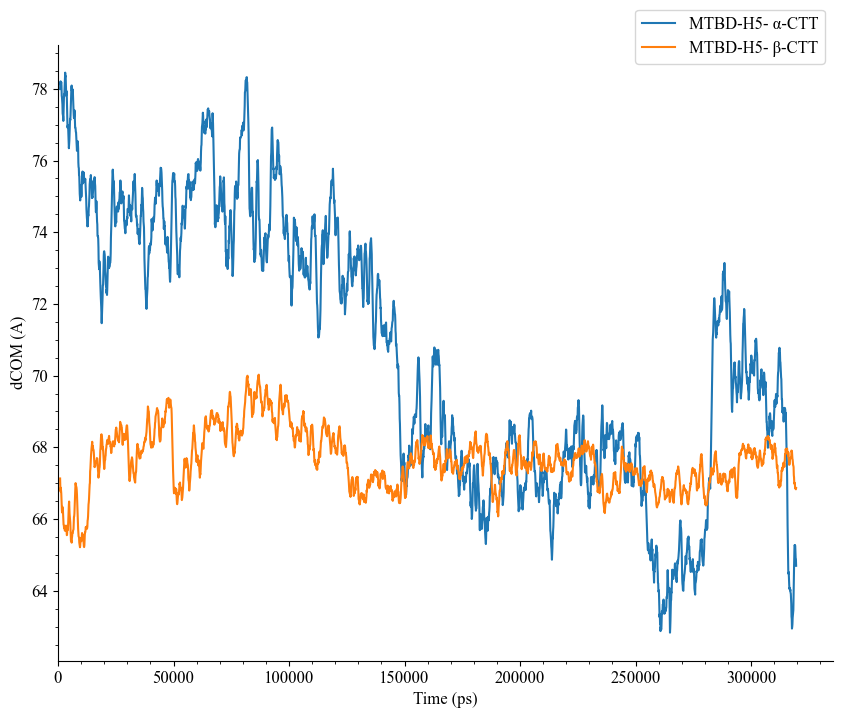

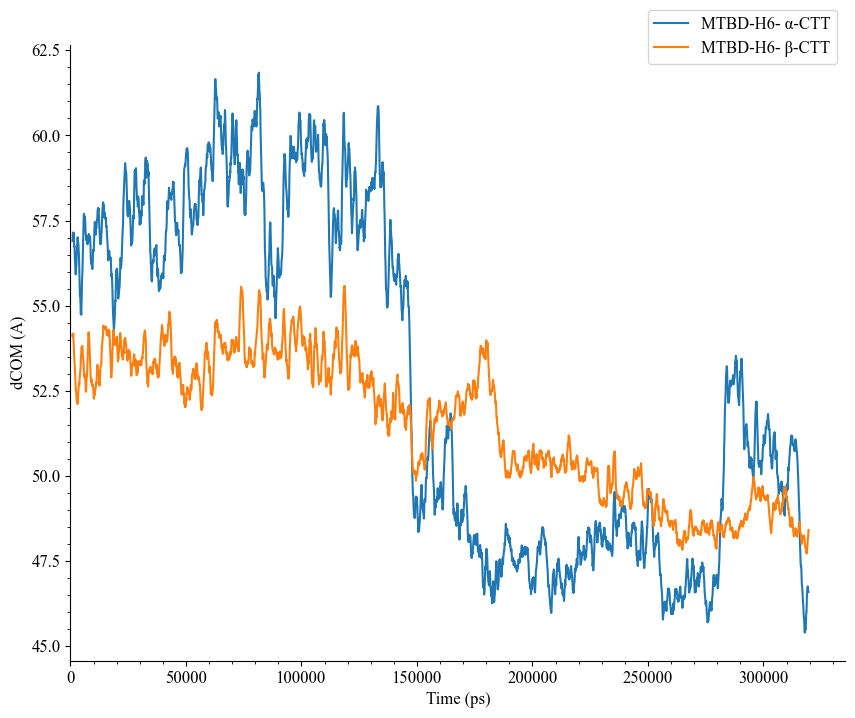

In [31]:
import MDAnalysis as mda
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Update the font to 'Times New Roman'
plt.rcParams["font.family"] = "Times New Roman"

# Update the font size to 12
plt.rcParams.update({'font.size': 12})

def setup_plot(x_label, y_label, xmin=None, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.tick_params(labelsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    if xmin is not None and xmax is not None:
        ax.set_xlim(left=xmin, right=(xmax*1.05))
    if ymin is not None and ymax is not None:
        ax.set_ylim(bottom=ymin, top=(ymax*1.20))

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    return fig, ax

# Initialize Universe with Gromacs files
u = mda.Universe('npt_modified.gro', 'centered_nojump_md.xtc')

# Select ct_alpha and ct_beta
ct_alpha = u.select_atoms('bynum 4368:4505')
ct_beta = u.select_atoms('bynum 8802:9035')

# Select the MTBD helices
mtbd_selections = {
    'MTBD-H1': u.select_atoms('resid 3301:3309'),
    'MTBD-H2': u.select_atoms('resid 3315:3329'),
    'MTBD-H3': u.select_atoms('resid 3335:3341'),
    'MTBD-H4': u.select_atoms('resid 3347:3352'),
    'MTBD-H5': u.select_atoms('resid 3361:3370'),
    'MTBD-H6': u.select_atoms('resid 3379:3385'),
}

# Dataframe to store dCOM results
df = pd.DataFrame()

# Time in ps
time = None

# Loop over each MTBD selection
for selection_name, selection in mtbd_selections.items():
    dcom_values_alpha = []
    dcom_values_beta = []
    for ts in u.trajectory:
        dcom_alpha = np.linalg.norm(ct_alpha.center_of_mass() - selection.center_of_mass())
        dcom_beta = np.linalg.norm(ct_beta.center_of_mass() - selection.center_of_mass())
        dcom_values_alpha.append(dcom_alpha)
        dcom_values_beta.append(dcom_beta)
    
    print(f"Initial dCOM for {selection_name} Alpha: {dcom_values_alpha[1]}")
    print(f"Final dCOM for {selection_name} Alpha: {dcom_values_alpha[-1]}")
    print(f"Initial dCOM for {selection_name} Beta: {dcom_values_beta[1]}")
    print(f"Final dCOM for {selection_name} Beta: {dcom_values_beta[-1]}")
    
    time = np.arange(len(dcom_values_alpha)) * u.trajectory.dt  # time in ps
    df[selection_name + ' Alpha DCOM (Å)'] = dcom_values_alpha
    df[selection_name + ' Beta DCOM (Å)'] = dcom_values_beta

# Append time to df
df['Time (ps)'] = time

# Smooth and plot DCOM for each selection
for selection_name in mtbd_selections.keys():
    df['Smoothed ' + selection_name + ' Alpha DCOM (Å)'] = df[selection_name + ' Alpha DCOM (Å)'].rolling(window=10).mean()
    df['Smoothed ' + selection_name + ' Beta DCOM (Å)'] = df[selection_name + ' Beta DCOM (Å)'].rolling(window=10).mean()

    # Use the setup_plot function to get the figure and axes
    fig, ax = setup_plot('Time (ps)', 'dCOM (Å)', xmin=0, xmax=max(time))

    # Plot the smoothed DCOM values using seaborn
    sns.lineplot(x='Time (ps)', y='Smoothed ' + selection_name + ' Alpha DCOM (Å)', data=df, ax=ax, label= selection_name + '- α-CTT')
    sns.lineplot(x='Time (ps)', y='Smoothed ' + selection_name + ' Beta DCOM (Å)', data=df, ax=ax, label= selection_name + '- β-CTT')

    # Show the legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.07))

    # Show the plot
    plt.show()

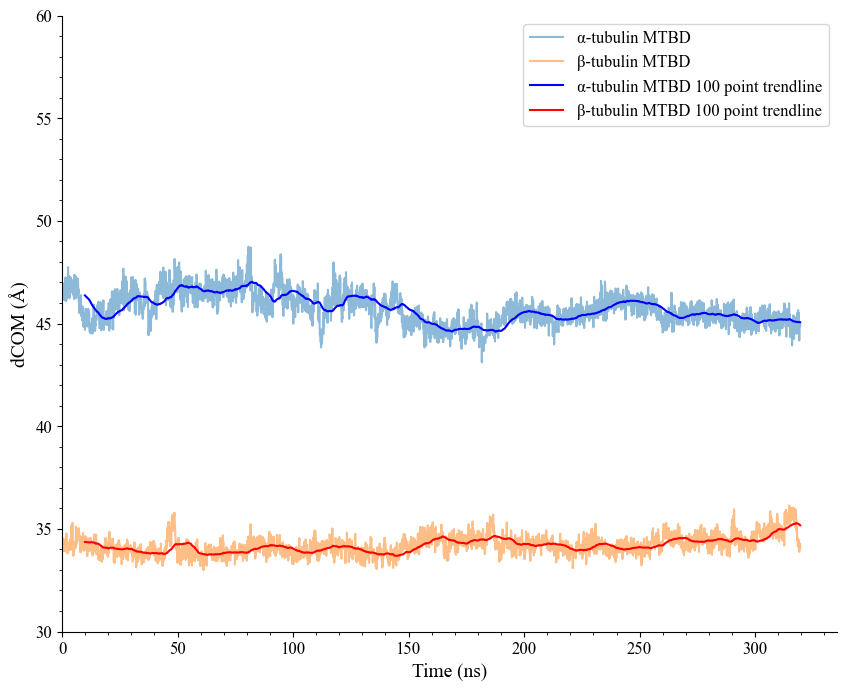

Initial dCOM for alpha:  46.45581561817398
Final dCOM for alpha:  44.91825587328335
Initial dCOM for beta:  34.5351272932084
Final dCOM for beta:  34.03533345290372
Average dCOM for the first 50 ns for alpha:  46.08346860458635
Average dCOM for the last 50 ns for alpha:  45.2517632969836
Average dCOM for the first 50 ns for beta:  34.102964985216744
Average dCOM for the last 50 ns for beta:  34.6697265037905


In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Update the font to 'Times New Roman'
plt.rcParams["font.family"] = "Times New Roman"

# Update the font size to 12
plt.rcParams.update({'font.size': 12})

# Your alpha, beta and mtbd selections
alpha = u.select_atoms('bynum 1:4368')
beta = u.select_atoms('bynum 4506:8802')
mtbd = u.select_atoms('bynum 9809:10726')

# Lists to store the dCOM values
dcom_values_alpha = []
dcom_values_beta = []

# Loop over the trajectory
for ts in u.trajectory:
    dcom_alpha = np.linalg.norm(alpha.center_of_mass() - mtbd.center_of_mass())
    dcom_beta = np.linalg.norm(beta.center_of_mass() - mtbd.center_of_mass())
    dcom_values_alpha.append(dcom_alpha)
    dcom_values_beta.append(dcom_beta)

# Generate the x-values (time in nanoseconds)
time = np.arange(len(dcom_values_alpha)) * u.trajectory.dt / 1000

# Create a DataFrame
df = pd.DataFrame({
    'Time (ns)': time, 
    'Alpha DCOM (Å)': dcom_values_alpha, 
    'Beta DCOM (Å)': dcom_values_beta
})

# Calculate the rolling average with a window size of 100
df['Smoothed Alpha DCOM (Å)'] = df['Alpha DCOM (Å)'].rolling(window=100).mean()
df['Smoothed Beta DCOM (Å)'] = df['Beta DCOM (Å)'].rolling(window=100).mean()

# Define the setup plot function

# Setup the plot
fig, ax = setup_plot('Time (ns)', 'dCOM (Å)', xmin=0, xmax=time.max(), ymin=30, ymax=60)

# Plot the original DCOM values using seaborn
sns.lineplot(x='Time (ns)', y='Alpha DCOM (Å)', data=df, ax=ax, label='α-tubulin MTBD', alpha=0.5)
sns.lineplot(x='Time (ns)', y='Beta DCOM (Å)', data=df, ax=ax, label='β-tubulin MTBD', alpha=0.5)

# Plot the smoothed DCOM values using seaborn
sns.lineplot(x='Time (ns)', y='Smoothed Alpha DCOM (Å)', data=df, ax=ax, label='α-tubulin MTBD 100 point trendline', color='b')
sns.lineplot(x='Time (ns)', y='Smoothed Beta DCOM (Å)', data=df, ax=ax, label='β-tubulin MTBD 100 point trendline', color='r')

plt.legend(loc='upper right')
plt.savefig("Final Graphs/Smoothed_DCOM_Alpha_Beta_MTBD.png", dpi=300)
plt.show()


# Print initial and final dCOM values for alpha
print("Initial dCOM for alpha: ", dcom_values_alpha[1])
print("Final dCOM for alpha: ", dcom_values_alpha[-1])

# Print initial and final dCOM values for beta
print("Initial dCOM for beta: ", dcom_values_beta[1])
print("Final dCOM for beta: ", dcom_values_beta[-1])

# Calculate and print average dCOM for the first 50 ns and the last 50 ns
print("Average dCOM for the first 50 ns for alpha: ", df.loc[df['Time (ns)'] <= 50, 'Alpha DCOM (Å)'].mean())
print("Average dCOM for the last 50 ns for alpha: ", df.loc[df['Time (ns)'] >= df['Time (ns)'].max() - 50, 'Alpha DCOM (Å)'].mean())
print("Average dCOM for the first 50 ns for beta: ", df.loc[df['Time (ns)'] <= 50, 'Beta DCOM (Å)'].mean())
print("Average dCOM for the last 50 ns for beta: ", df.loc[df['Time (ns)'] >= df['Time (ns)'].max() - 50, 'Beta DCOM (Å)'].mean())


In [80]:
def setup_plot(x_label, y_label, xmin=0, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(left=xmin, right=(xmax*1.05))
    ax.set_ylim(bottom=ymin, top=(ymax))
    
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(labelsize=12)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)


    return fig, ax

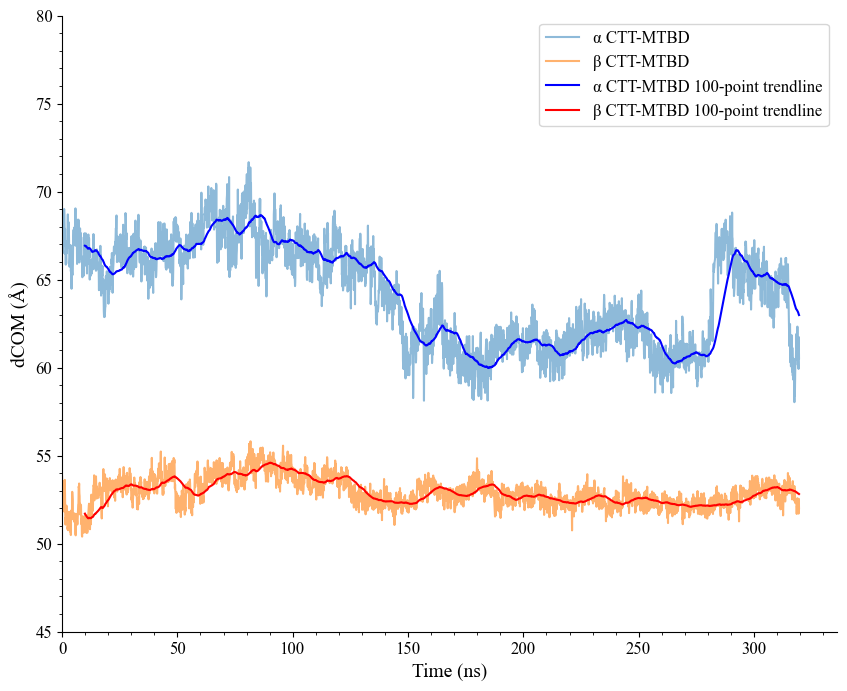

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def setup_plot(x_label, y_label, xmin=0, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(left=xmin, right=(xmax*1.05))
    ax.set_ylim(bottom=ymin, top=(ymax))
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(labelsize=12)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    return fig, ax

def calculate_dcom(reference, target):
    return np.linalg.norm(reference.center_of_mass() - target.center_of_mass())

dcom_values_ct_alpha = []
dcom_values_ct_beta = []

for ts in u.trajectory:
    dcom_values_ct_alpha.append(calculate_dcom(ct_alpha, mtbd))
    dcom_values_ct_beta.append(calculate_dcom(ct_beta, mtbd))

time = np.arange(len(dcom_values_ct_alpha)) * u.trajectory.dt / 1000

df = pd.DataFrame({
    'Time (ns)': time, 
    'CT_Alpha DCOM (Å)': dcom_values_ct_alpha, 
    'CT_Beta DCOM (Å)': dcom_values_ct_beta
})

window_size = 100
df['Smoothed CT_Alpha DCOM (Å)'] = df['CT_Alpha DCOM (Å)'].rolling(window=window_size).mean()
df['Smoothed CT_Beta DCOM (Å)'] = df['CT_Beta DCOM (Å)'].rolling(window=window_size).mean()

fig, ax = setup_plot('Time (ns)', 'dCOM (Å)', xmin=0, xmax=320, ymin=45, ymax=80)

start = 0
stop = 320
interval = 20
steps = int((stop - start) / interval) + 1

x_ticks = np.linspace(start, stop, steps)


sns.lineplot(x='Time (ns)', y='CT_Alpha DCOM (Å)', data=df, ax=ax, label='α CTT-MTBD', alpha=0.5)
sns.lineplot(x='Time (ns)', y='CT_Beta DCOM (Å)', data=df, ax=ax, label='β CTT-MTBD', alpha=0.6)
sns.lineplot(x='Time (ns)', y='Smoothed CT_Alpha DCOM (Å)', data=df, ax=ax, label='α CTT-MTBD 100-point trendline', color='b')
sns.lineplot(x='Time (ns)', y='Smoothed CT_Beta DCOM (Å)', data=df, ax=ax, label='β CTT-MTBD 100-point trendline', color='r')

legend = plt.legend(loc='upper right')
plt.setp(legend.get_texts(), color='black')

plt.savefig("Final Graphs/Smoothed_DCOM_CT_a_b_MTBD.png", dpi=300)
plt.show()
plt.close()


In [15]:
# Calculate averages for first and last 50 ns
first_50_ns_alpha = df[df['Time (ns)'] <= 50]['CT_Alpha DCOM (Å)'].mean()
last_50_ns_alpha = df[df['Time (ns)'] >= df['Time (ns)'].max() - 50]['CT_Alpha DCOM (Å)'].mean()

first_50_ns_beta = df[df['Time (ns)'] <= 50]['CT_Beta DCOM (Å)'].mean()
last_50_ns_beta = df[df['Time (ns)'] >= df['Time (ns)'].max() - 50]['CT_Beta DCOM (Å)'].mean()

# Print initial and final dCOM values for alpha
print("Initial dCOM for alpha: ", dcom_values_ct_alpha[1])
print("Final dCOM for alpha: ", dcom_values_ct_alpha[-1])
print("Average DCOM for first 50 ns for alpha: ", first_50_ns_alpha)
print("Average DCOM for last 50 ns for alpha: ", last_50_ns_alpha)

# Print initial and final dCOM values for beta
print("Initial dCOM for beta: ", dcom_values_ct_beta[1])
print("Final dCOM for beta: ", dcom_values_ct_beta[-1])
print("Average DCOM for first 50 ns for beta: ", first_50_ns_beta)
print("Average DCOM for last 50 ns for beta: ", last_50_ns_beta)

Initial dCOM for alpha:  66.8667304860205
Final dCOM for alpha:  60.53039295355526
Average DCOM for first 50 ns for alpha:  66.38703699269217
Average DCOM for last 50 ns for alpha:  63.89600567527833
Initial dCOM for beta:  52.813271151848426
Final dCOM for beta:  52.011098304841795
Average DCOM for first 50 ns for beta:  52.86244416297702
Average DCOM for last 50 ns for beta:  52.61245034222494


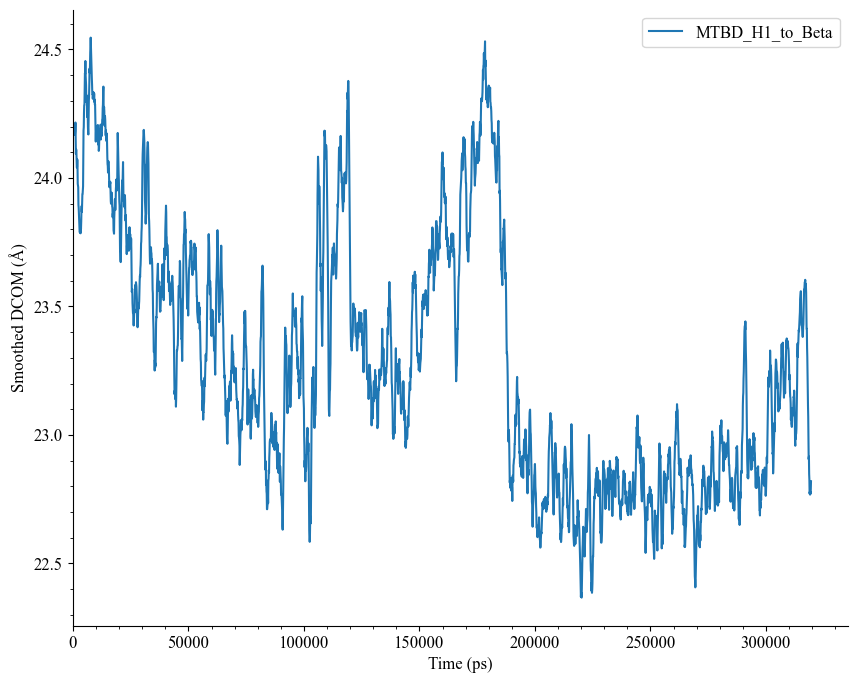

For MTBD_H1_to_Beta, initial dCOM: 23.91591119263424, final dCOM: 22.82896003638593


In [7]:
# Function to calculate dCOM between two selections
import pandas as pd
import seaborn as sns
def calculate_dcom(selection1, selection2):
    dcom_values = []
    for ts in u.trajectory:
        dcom = np.linalg.norm(selection1.center_of_mass() - selection2.center_of_mass())
        dcom_values.append(dcom)
    return dcom_values

# Select MTBD H1 and beta
selections = {
    'MTBD_H1_to_Beta': (u.select_atoms('resid 3301:3309'), beta),
}

# Dataframe to store dCOM results
df = pd.DataFrame()

# Time in ps
time = None

# Loop over each selection
for selection_name, (selection1, selection2) in selections.items():
    dcom_values = calculate_dcom(selection1, selection2)
    time = np.arange(len(dcom_values)) * u.trajectory.dt  # time in ps
    df[selection_name + ' DCOM (Å)'] = dcom_values

# Append time to df
df['Time (ps)'] = time

# Smooth and plot DCOM for each selection
for selection_name in selections.keys():
    df['Smoothed ' + selection_name + ' DCOM (Å)'] = df[selection_name + ' DCOM (Å)'].rolling(window=10).mean()

    # Use the setup_plot function to get the figure and axes
    fig, ax = setup_plot('Time (ps)', 'Smoothed DCOM (Å)', xmin=0, xmax=max(time))

    # Plot the smoothed DCOM values using seaborn
    sns.lineplot(x='Time (ps)', y='Smoothed ' + selection_name + ' DCOM (Å)', data=df, ax=ax, label=selection_name)

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()
    
    print(f"For {selection_name}, initial dCOM: {dcom_values[0]}, final dCOM: {dcom_values[-1]}")


In [91]:
import MDAnalysis as mda
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Update the font to 'Times New Roman'
plt.rcParams["font.family"] = "Times New Roman"

# Update the font size to 12
plt.rcParams.update({'font.size': 12})

def setup_plot(x_label, y_label, xmin=None, xmax=None, ymin=None, ymax=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.tick_params(labelsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    if xmin is not None and xmax is not None:
        ax.set_xlim(left=xmin, right=(xmax*1.05))
    if ymin is not None and ymax is not None:
        ax.set_ylim(bottom=ymin, top=(ymax*1.15))

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    return fig, ax

In [112]:
# Initialize Universe with Gromacs files
u = mda.Universe('npt_modified.gro', 'centered_nojump_md.xtc')

# Select ct_alpha and ct_beta
alpha = u.select_atoms('bynum 1:4368')
beta = u.select_atoms('bynum 4506:8802')
# Select the MTBD helices
mtbd_selections = {
    'MTBD-H1': u.select_atoms('resid 3301:3309'),
    'MTBD-H2': u.select_atoms('resid 3315:3329'),
    'MTBD-H3': u.select_atoms('resid 3335:3341'),
    'MTBD-H4': u.select_atoms('resid 3347:3352'),
    'MTBD-H5': u.select_atoms('resid 3361:3370'),
    'MTBD-H7': u.select_atoms('resid 3379:3385'),
}